# Example 4: Calculate fault slip
This example describes how to correlate faults extracted at different time steps.

Now we can load the python packages:

In [2]:
import math
import pickle

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

from fatbox.metrics import total_length
from fatbox.plots import plot_faults, plot_components, plot_attribute

## Load and plot faults

First, we load our fault networks extracted from a 2-D model over several timesteps:

In [5]:
#G = pickle.load(open('graphs/g_3.p', 'rb'))
G = pickle.load(open('/home/lxue07/Documents/ThermoMech2d/ForLiang_ThermoMech2D/\
ForLiang_ThermoMech2D/output/AfricaModels2022/Mat/test.p', 'rb'))

Now we can visualize these faults:

KeyError: 'fault'

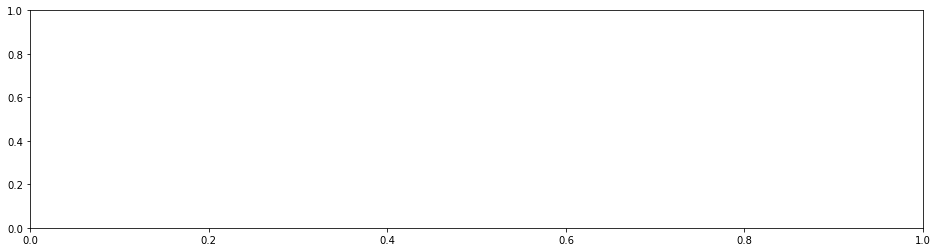

In [6]:
fig, ax = plt.subplots(figsize=(16,4))
plot_faults(G, ax = ax,node_size =1 )
plt.xlim([1000, 3500])
plt.ylim([600, 0])
plt.show()

Load velocities in x- and z-direction:

In [8]:
!p7zip -d './fatbox_tutorials/4-fault_slip/velocity.7z'
!mv velocity.npy './fatbox_tutorials/4-fault_slip/'

/usr/bin/p7zip: cannot read ./fatbox_tutorials/4-fault_slip/velocity.7z
mv: cannot stat 'velocity.npy': No such file or directory


In [9]:
data = np.load('velocity.npy')

v_x  = data[:,:,0]
v_z  = data[:,:,1]

Visualize the velocity in z-direction:

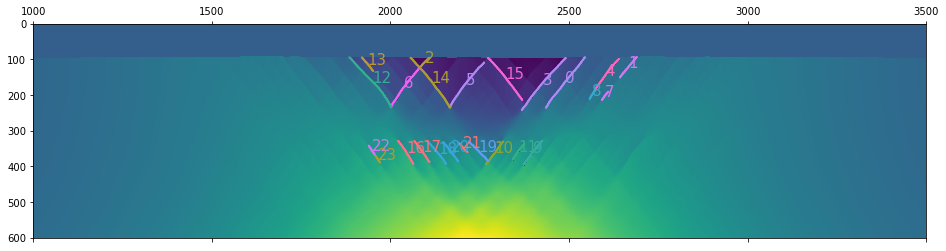

In [13]:
fig, ax = plt.subplots(figsize=(16,4))
plot_faults(G, ax = ax, node_size=1.0)
ax.matshow(v_z)
plt.xlim([1000, 3500])
plt.ylim([600, 0])
plt.show()

## Extract velocities
Now we want to pick up the velocity left and right of each fault, but to do this we first need to calculate the direction of the fault:

In [4]:
def calculate_direction(G, cutoff, normalize=True):

    for node in G.nodes:            
        length = nx.single_source_shortest_path_length(G, node, cutoff=cutoff)
        keys = [keys for keys,values in length.items() if values == max(length.values())]        
        if len(keys) >  2:
            (node_0, node_1) = keys[:2]
        if len(keys) == 2:
            (node_0, node_1) = keys
        if len(keys) == 1:
            node_0 = keys[0]
            
            length = nx.single_source_shortest_path_length(G, node, cutoff=cutoff-1)
            keys = [keys for keys,values in length.items() if values == max(length.values())]
            
            node_1 = keys[0]

        # extrac position
        pt_0 = G.nodes[node_0]['pos']
        pt_1 = G.nodes[node_1]['pos']                  
        # calculate vector              
        dx = pt_0[0] - pt_1[0]
        dy = pt_0[1] - pt_1[1]            
        # write to graph
        G.nodes[node]['dx'] = dx
        G.nodes[node]['dy'] = dy   
             
    return G

G = calculate_direction(G, 3)

Now we use the direction to calculate the pick-up points:

In [5]:
def calculate_pickup_points(G, factor):

    H = nx.Graph() 
    
    for node in G.nodes:
        
        (x, y) = G.nodes[node]['pos']
        
        dx = G.nodes[node]['dx']
        dy = G.nodes[node]['dy']
        
        dx = factor * dx
        dy = factor * dy
    
        x_p = int(x - dy)
        y_p = int(y + dx)
    
        x_n = int(x + dy)
        y_n = int(y - dx)
    
        node_mid = (node, 0)
        H.add_node(node_mid)
        H.nodes[node_mid]['pos'] = (x, y)
        H.nodes[node_mid]['component']  = -1
    
        node_p = (node, 1)
        H.add_node(node_p)
        H.nodes[node_p]['pos'] = (x_p, y_p)
        H.nodes[node_p]['component']  = -2
    
        node_n = (node, 2)
        H.add_node(node_n)
        H.nodes[node_n]['pos'] = (x_n, y_n)
        H.nodes[node_n]['component']  = -3
    
    
        H.add_edge(node_n, node_p)
                
    return H

H = calculate_pickup_points(G, 1)

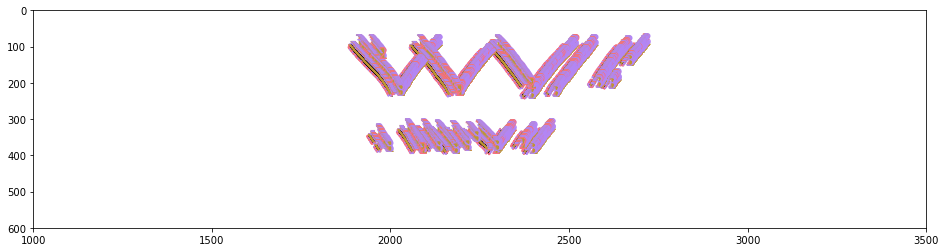

In [8]:
fig, ax = plt.subplots(figsize=(16,4))
plot_components(H, ax = ax, node_size = 1)
#ax.matshow(v_z)
plt.xlim([1000, 3500])
plt.ylim([600, 0])
plt.show()

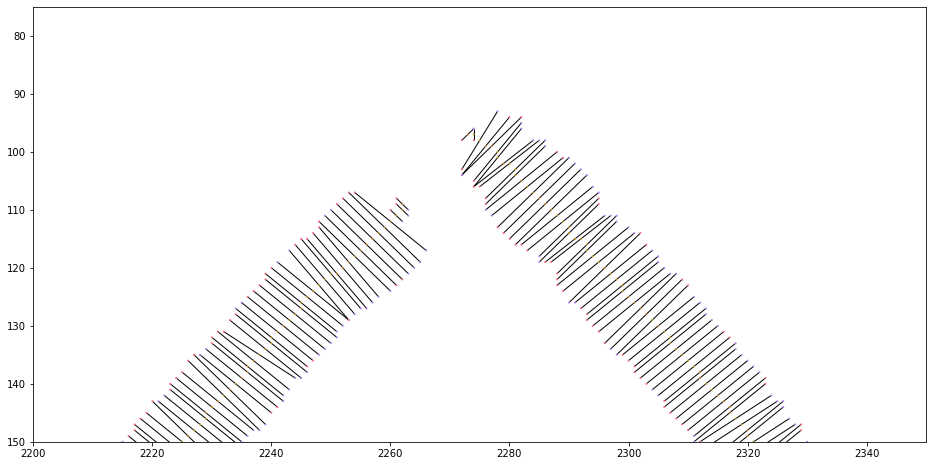

In [11]:
fig, ax = plt.subplots(figsize=(16,8))
plot_components(H, ax = ax, node_size = 1, label=False)
#ax.matshow(v_z)
plt.xlim([2200, 2350])
plt.ylim([150, 75])
plt.show()

In [12]:
def extract_attribute(G, image, name):
    (x_max, y_max) = image.shape   
    for node in G:
        y,x = G.nodes[node]['pos']
        if x >= x_max or y>=y_max:
            G.nodes[node][name] = float('nan')        
        else:
            G.nodes[node][name] = image[int(x),int(y)]
    return G

H = extract_attribute(H, v_x, 'v_x')
H = extract_attribute(H, v_z, 'v_z')

NameError: name 'v_x' is not defined

In [15]:
def filter_pickup_points(G, H):    
    for node in G:      
        if H.nodes[(node, 1)]['pos'][1] < 0 or H.nodes[(node, 2)]['pos'][1] < 0:
            
            H.nodes[(node,0)]['v_x'] = 0
            H.nodes[(node,0)]['v_z'] = 0
    
            H.nodes[(node,1)]['v_x'] = 0
            H.nodes[(node,1)]['v_z'] = 0
    
            H.nodes[(node,2)]['v_x'] = 0
            H.nodes[(node,2)]['v_z'] = 0

    return H

H = filter_pickup_points(G, H)

## Compute slip and slip rate

In [16]:
def calculate_slip_rate(G, H, dim):
    if dim == 2:
        for node in H.nodes:
            if node[1] == 0:    # centre point
            
                if H.nodes[(node[0], 1)]['v_x'] == 0 or H.nodes[(node[0], 2)]['v_x'] == 0:
                    G.nodes[node[0]]['slip_rate_x'] =  0
                    G.nodes[node[0]]['slip_rate_z'] =  0
                    G.nodes[node[0]]['slip_rate']   =  0
                else:            
                    G.nodes[node[0]]['slip_rate_x'] =  abs((H.nodes[(node[0], 1)]['v_x'] - H.nodes[(node[0], 2)]['v_x']))
                    G.nodes[node[0]]['slip_rate_z'] =  abs((H.nodes[(node[0], 1)]['v_z'] - H.nodes[(node[0], 2)]['v_z']))
                    G.nodes[node[0]]['slip_rate']   =  math.sqrt(G.nodes[node[0]]['slip_rate_x']**2 + G.nodes[node[0]]['slip_rate_z']**2)
    if dim == 3:
        for node in H.nodes:
            if node[1] == 0:    # centre point   
                # Outside of the box
                if H.nodes[(node[0], 1)]['v_x'] == 0 or H.nodes[(node[0], 2)]['v_x'] == 0:
                    G.nodes[node[0]]['slip_rate_x'] =  0
                    G.nodes[node[0]]['slip_rate_y'] =  0
                    G.nodes[node[0]]['slip_rate_z'] =  0
                    G.nodes[node[0]]['slip_rate']   =  0        
                # Inside the box
                else:            
                    G.nodes[node[0]]['slip_rate_x'] =  abs((H.nodes[(node[0], 1)]['v_x'] - H.nodes[(node[0], 2)]['v_x']))
                    G.nodes[node[0]]['slip_rate_y'] =  abs((H.nodes[(node[0], 1)]['v_y'] - H.nodes[(node[0], 2)]['v_y']))
                    G.nodes[node[0]]['slip_rate_z'] =  abs((H.nodes[(node[0], 1)]['v_z'] - H.nodes[(node[0], 2)]['v_z']))
                    G.nodes[node[0]]['slip_rate']   =  math.sqrt(G.nodes[node[0]]['slip_rate_x']**2 + 
                                                                 G.nodes[node[0]]['slip_rate_y']**2 + 
                                                                 G.nodes[node[0]]['slip_rate_z']**2)        
        
    return G

G = calculate_slip_rate(G, H, dim=2)

In [17]:
def calculate_slip(G, H, dt, dim):
    if dim == 2:
        for node in H.nodes:
            if node[1] == 0:
                
                if H.nodes[(node[0], 1)]['v_x'] == 0 or H.nodes[(node[0], 2)]['v_x'] == 0:
                    G.nodes[node[0]]['slip_x'] =  0
                    G.nodes[node[0]]['slip_z'] =  0
                    G.nodes[node[0]]['slip']   =  0
                else:            
                    G.nodes[node[0]]['slip_x'] =  abs((H.nodes[(node[0], 1)]['v_x'] - H.nodes[(node[0], 2)]['v_x']))*dt
                    G.nodes[node[0]]['slip_z'] =  abs((H.nodes[(node[0], 1)]['v_z'] - H.nodes[(node[0], 2)]['v_z']))*dt
                    G.nodes[node[0]]['slip']   =  math.sqrt(G.nodes[node[0]]['slip_x']**2 + G.nodes[node[0]]['slip_z']**2)
                                                            
    if dim == 3:
        for node in H.nodes:
            if node[1] == 0:
                
                if H.nodes[(node[0], 1)]['v_x'] == 0 or H.nodes[(node[0], 2)]['v_x'] == 0:
                    G.nodes[node[0]]['slip_x'] =  0
                    G.nodes[node[0]]['slip_y'] =  0
                    G.nodes[node[0]]['slip_z'] =  0
                    G.nodes[node[0]]['slip']   =  0
                else:            
                    G.nodes[node[0]]['slip_x'] =  abs((H.nodes[(node[0], 1)]['v_x'] - H.nodes[(node[0], 2)]['v_x']))*dt
                    G.nodes[node[0]]['slip_y'] =  abs((H.nodes[(node[0], 1)]['v_y'] - H.nodes[(node[0], 2)]['v_y']))*dt
                    G.nodes[node[0]]['slip_z'] =  abs((H.nodes[(node[0], 1)]['v_z'] - H.nodes[(node[0], 2)]['v_z']))*dt
                    G.nodes[node[0]]['slip']   =  math.sqrt(G.nodes[node[0]]['slip_x']**2 + 
                                                            G.nodes[node[0]]['slip_y']**2 + 
                                                            G.nodes[node[0]]['slip_z']**2)
    return G

G = calculate_slip(G, H, dim=2, dt=94804)

## Visualization


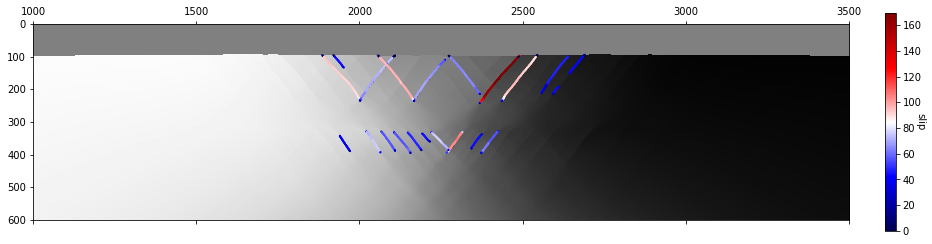

In [18]:
fig, ax = plt.subplots(figsize=(16,4))
plot_attribute(G, 'slip', ax)
ax.matshow(v_x, cmap='gray')
plt.xlim([1000, 3500])
plt.ylim([600, 0])
plt.show()

In [19]:
def get_fault_labels(G):
    labels=set()
    for node in G:
        labels.add(G.nodes[node]['fault'])
    return sorted(list(labels))

def get_fault(G, n):
    nodes = [node for node in G if G.nodes[node]['fault']==n]
    return G.subgraph(nodes)


labels = get_fault_labels(G)

lengths = []
slips   = []
for label in labels:
    fault = get_fault(G, label)
    lengths.append(total_length(fault))
    slips.append(np.max([fault.nodes[node]['slip'] for node in fault]))


In [20]:
G.nodes[10]

{'component': 0,
 'dx': -5,
 'dy': 6,
 'edges': 2,
 'fault': 0,
 'polarity': 0,
 'pos': (2538, 104),
 'slip': 90.22910443105594,
 'slip_rate': 0.0009517436440556932,
 'slip_rate_x': 0.0005521000000000002,
 'slip_rate_z': 0.0007752429,
 'slip_x': 52.341288400000025,
 'slip_z': 73.4961278916}

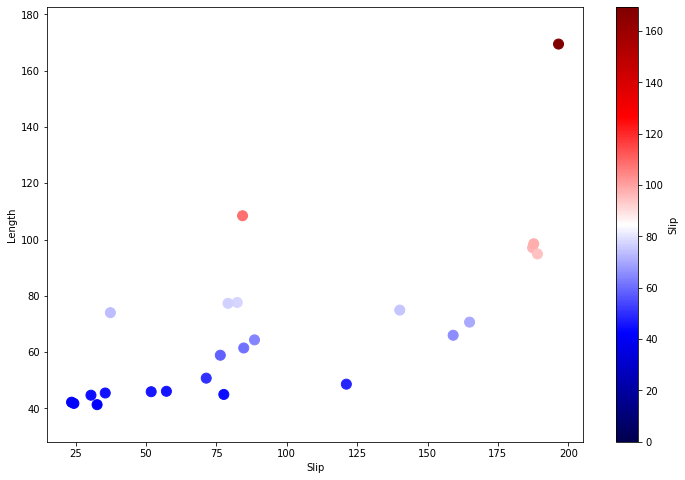

In [21]:
plt.figure(figsize=(12,8))
plt.scatter(lengths, slips, c=slips, s=100, cmap='seismic', vmin=0)
plt.xlabel('Slip')
plt.ylabel('Length')
plt.axis('equal')
cbar=plt.colorbar()
cbar.set_label('Slip')
plt.show()